In [ ]:
# Author : Raude Killian
# Last modified 17.07.2025

In [8]:
import mne
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import warnings
from scipy.stats import ttest_rel
%matplotlib inline


PARTICIPANTS_FILE = r"L:\Common\Users\Qiaoyue\MEG_project\Data\participants.csv"

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

participants = pd.read_csv(PARTICIPANTS_FILE)  
participants = participants['subID'].astype(str).tolist()
sessions = ["encoding"]

print(f"✅ Participant list : {participants}")

✅ Participant list : ['F103', 'F104', 'F105', 'F106', 'F107', 'F108', 'F109', 'F111', 'F112', 'F113', 'F114', 'F115', 'F116', 'F117', 'F118', 'F119', 'F120', 'F122', 'F123']


In [9]:
# For tests purposes
#participants = ["F103"]

In [10]:
evoked_all_cong = []
evoked_all_incong = []

for subID in participants:

    plots_folder = rf"L:\Common\Users\Qiaoyue\MEG_project\Results\plots"
    os.makedirs(plots_folder, exist_ok=True)
    intermediates_folder = rf"L:\Common\Users\Qiaoyue\MEG_project\Results\finals\{subID}"
    #intermediates_folder = rf"C:\Users\killg\Desktop\finals\{subID}"
    os.makedirs(intermediates_folder, exist_ok=True)

    # Declare filenames 
    evoked_filename = rf"{intermediates_folder}/{subID}_encod_cong_evoked.fif"
    evoked = mne.read_evokeds(evoked_filename, verbose=False)[0]
    evoked_all_cong.append(evoked)

    evoked_filename = rf"{intermediates_folder}/{subID}_encod_incong_evoked.fif"
    evoked = mne.read_evokeds(evoked_filename, verbose=False)[0]
    evoked_all_incong.append(evoked)

    print(f"Extracting evoked: {subID}... ")
print(f"✅ Done")

Extracting evoked: F103... 
Extracting evoked: F104... 
Extracting evoked: F105... 
Extracting evoked: F106... 
Extracting evoked: F107... 
Extracting evoked: F108... 
Extracting evoked: F109... 
Extracting evoked: F111... 
Extracting evoked: F112... 
Extracting evoked: F113... 
Extracting evoked: F114... 
Extracting evoked: F115... 
Extracting evoked: F116... 
Extracting evoked: F117... 
Extracting evoked: F118... 
Extracting evoked: F119... 
Extracting evoked: F120... 
Extracting evoked: F122... 
Extracting evoked: F123... 
✅ Done


Mean cong : 3.36 ± 1.50 
Mean incong : 3.81 ± 1.94
t = -2.585, p = 0.019
Cohen's d = -0.593


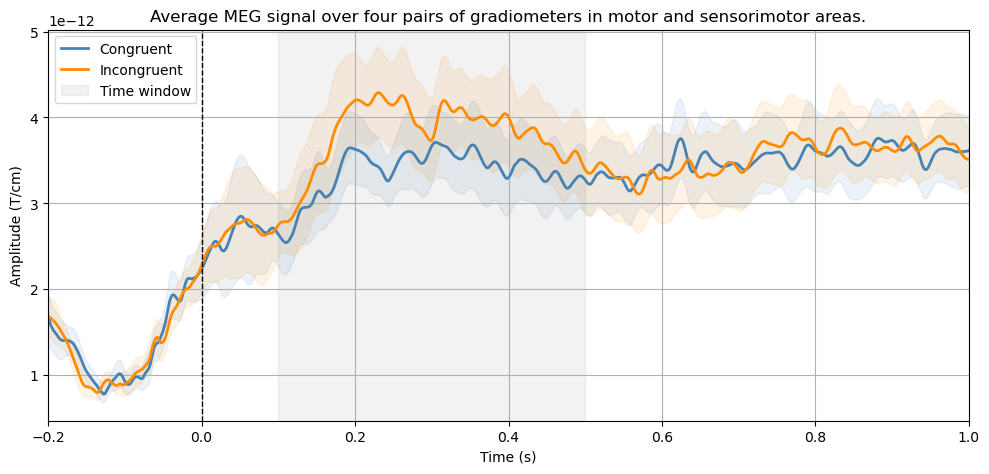

Identifying common channels ...
Identifying common channels ...


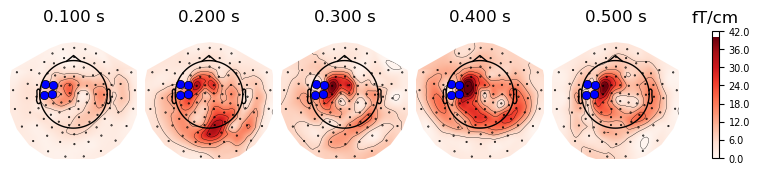

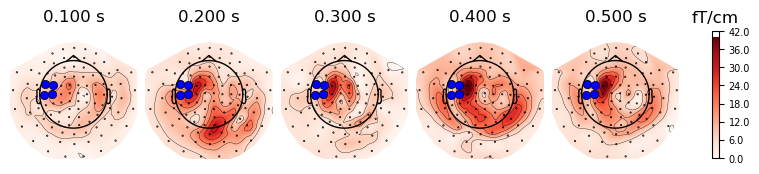

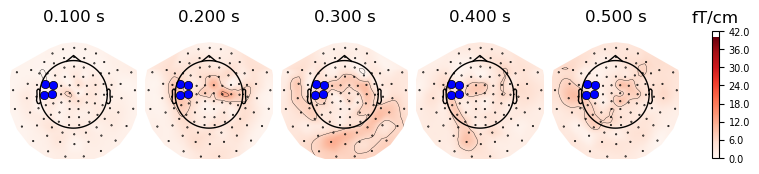

In [13]:
# Define arbitrary list of gradiometer pairs 
gradiometer_pairs = [
    ["MEG0222", "MEG0232"], 
    ["MEG0442", "MEG0443"],
    ["MEG0412", "MEG0413"],
    ["MEG0232", "MEG0233"]  
]

# Extract first gradiometer of each pair for topomap masking
topomap_channels = [pair[0] for pair in gradiometer_pairs]

cong_data = []
incong_data = []

# Function to compute mean magnitude over all pairs 
def compute_mean_magnitude(evoked, pairs):
    magnitudes = []
    for pair in pairs:
        item = evoked.copy().pick(pair)
        mag = np.sqrt(item.data[0]**2 + item.data[1]**2)
        magnitudes.append(mag)
    mean_mag = np.mean(magnitudes, axis=0)
    return mean_mag

# Loop over congruent trials 
for evoked in evoked_all_cong:
    mean_mag = compute_mean_magnitude(evoked, gradiometer_pairs)
    cong_data.append(mean_mag)

# Loop over incongruent trials 
for evoked in evoked_all_incong:
    mean_mag = compute_mean_magnitude(evoked, gradiometer_pairs)
    incong_data.append(mean_mag)

# Prepare time axis
time = np.linspace(-0.5, 2, len(cong_data[0]))

# Compute mean and standard error across trials
cong_data = np.array(cong_data)
incong_data = np.array(incong_data)

cong_mean_signal = np.mean(cong_data, axis=0)
cong_se_signal = np.std(cong_data, axis=0) / np.sqrt(len(cong_data))
incong_mean_signal = np.mean(incong_data, axis=0)
incong_se_signal = np.std(incong_data, axis=0) / np.sqrt(len(incong_data))

# Time window for amplitude analysis
lower_t = 0.1
upper_t = 0.5
time_window = (time >= lower_t) & (time <= upper_t)

# Average amplitudes in time window
cong_amplitudes = np.mean(cong_data[:, time_window], axis=1)
incong_amplitudes = np.mean(incong_data[:, time_window], axis=1)

# Print stats 
scale_factor = 1e12  
print(f"Mean cong : {np.mean(cong_amplitudes * scale_factor):.2f} ± {np.std(cong_amplitudes * scale_factor):.2f} ")
print(f"Mean incong : {np.mean(incong_amplitudes * scale_factor):.2f} ± {np.std(incong_amplitudes * scale_factor):.2f}")

# Paired t-test
t_stat, p_value = ttest_rel(cong_amplitudes, incong_amplitudes)
print(f"t = {t_stat:.3f}, p = {p_value:.3f}")

# Cohen's d
diff = cong_amplitudes - incong_amplitudes
cohen_d = np.mean(diff) / np.std(diff, ddof=1)
print(f"Cohen's d = {cohen_d:.3f}")

# Plot time courses
plt.figure(figsize=(10, 5))
plt.plot(time, cong_mean_signal, label='Congruent', color='steelblue', linewidth=2)
plt.fill_between(time, cong_mean_signal - cong_se_signal, cong_mean_signal + cong_se_signal,
                 color='steelblue', alpha=0.1)
plt.plot(time, incong_mean_signal, label='Incongruent', color='darkorange', linewidth=2)
plt.fill_between(time, incong_mean_signal - incong_se_signal, incong_mean_signal + incong_se_signal,
                 color='darkorange', alpha=0.1)

plt.xlabel('Time (s)')
plt.ylabel('Amplitude (T/cm)')

plt.title(f'Average MEG signal over four pairs of gradiometers in motor and sensorimotor areas.')
plt.xlim(-0.2, 1)
plt.axvline(x=0, linestyle='--', linewidth=1, color='black')
plt.axvspan(lower_t, upper_t, color='grey', alpha=0.1, label = 'Time window')
plt.grid(True)
plt.tight_layout()
plt.legend(loc="upper left")
plt.savefig(rf"{plots_folder}\SignalEncod.png", dpi = 1200)
plt.show()

# Topomaps
times = np.arange(lower_t, upper_t + 0.02, 0.1)
vmin, vmax = 0, 40

avg_cong = mne.grand_average(evoked_all_cong, interpolate_bads=False)
avg_incong = mne.grand_average(evoked_all_incong, interpolate_bads=False)
diff_cong_incong_evoked = mne.combine_evoked([avg_cong, avg_incong], weights=[1, -1])

# Create mask for selected gradiometers
n_channels = len(avg_cong.ch_names)
n_times = len(avg_cong.times)
mask = np.zeros((n_channels, n_times), dtype=bool)

for chan in topomap_channels:
    chan_idx = avg_cong.ch_names.index(chan)
    time_idxs = [np.argmin(np.abs(avg_cong.times - t)) for t in times]
    for t in time_idxs:
        mask[chan_idx, t] = True

mask_params = dict(markersize=12, markerfacecolor="blue")

# Plot topomaps
fig = avg_cong.plot_topomap(times, ch_type="grad", show=False,
                            vlim=(vmin, vmax), mask=mask, mask_params=mask_params)
plt.savefig(rf"{plots_folder}\TopoCongEncod.png", dpi = 1200)
plt.show()

fig = avg_incong.plot_topomap(times, ch_type="grad", show=False,
                              vlim=(vmin, vmax), mask=mask, mask_params=mask_params)
plt.savefig(rf"{plots_folder}\TopoIncongEncod.png", dpi = 1200)
plt.show()

fig = diff_cong_incong_evoked.plot_topomap(times, ch_type="grad", show=False,
                                           vlim=(vmin, vmax), mask=mask, mask_params=mask_params)
plt.savefig(rf"{plots_folder}\TopoCongIncongEncod.png", dpi = 1200)
plt.show()
